In [1]:
# NOTE: !!! THIS CELL SHOULD BE RUN FIRST !!!

# Jupyter notebooks have a bad interaction with virtual environments: 
# they perceive the PYTHONPATH as the folder the venv was activated
# instead of whatever the current directory of the .ipynb file is
# so we need to incorporate this hack

import sys

filepath = "/Users/colinyao/Desktop/Code/FINM/FixedIncome_37400"
# change this path to whatever the path to this file is on your computer
sys.path.append(filepath)

import os
os.chdir(filepath)

In [2]:
import pandas as pd
from sklearn.linear_model import LinearRegression as LR
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import datetime as dt
import scipy

In [3]:
# reading in data

selected_quotes = pd.read_excel("./data/treasury_quotes_2025-11-28.xlsx", sheet_name='selected quotes', index_col=0)
quotes = pd.read_excel("./data/treasury_quotes_2025-11-28.xlsx", sheet_name='quotes', index_col=0)


# Treasury Arbitrage
## 1.1

In [32]:
quote_date = dt.date(2023, 12, 29)
maturity_date = dt.date(2029, 8, 15)

old_coupon = 6.12
new_coupon = 1.62

old_price = 111.04
new_price = 89.03

old_accrued_interest = 2.26
new_accrued_interest = 0.60

coupon_dates = []

while maturity_date > quote_date:
    coupon_dates.append(maturity_date)
    maturity_date = maturity_date - dt.timedelta(days=182)  # approx 6 months

coupon_dates = sorted(coupon_dates)

def discount_cashflows(coupon, ytm, coupon_dates, quote_date):
    # assume coupon diff and discount rate quoted annually
    # but compounded semiannually

    pv = 0
    for i, date in enumerate(coupon_dates):
        ttm = (date - quote_date).days / 365.25
        cashflow = coupon / 2 if i != len(coupon_dates) - 1 else coupon / 2 + 100
        pv += cashflow / ((1 + ytm / 2) ** (ttm * 2))
    return pv

def fit_yield_to_maturity(coupon, market_price, coupon_dates, quote_date):
    # use numerical method to fit discount rate
    func = lambda r: (discount_cashflows(coupon, r, coupon_dates, quote_date) - market_price) ** 2
    return scipy.optimize.minimize(func, x0=0.04).x[0]

fitted_ytm = fit_yield_to_maturity(old_coupon - new_coupon, old_price - new_price + old_accrued_interest - new_accrued_interest, coupon_dates, quote_date)
print(f"Fitted YTM: {fitted_ytm}")
print(f"PV at 5%: {discount_cashflows(old_coupon - new_coupon, 0.05, coupon_dates, quote_date)}")


Fitted YTM: 0.4071811838005359
PV at 5%: 99.22561042485577


From this we conclude that we would prefer to go long the T-bond and short the T-note. The payoffs are such that we prefer to invest the difference upfront in order to receive the guaranteed future cashflow unless our rate of return outside of these investments are extremely high. 

Alternatively, we observe that the yield-to-maturity is higher for the second bond than the first. As both the bonds are over the same time period and incur the same risks, going long the bond with higher YTM and short the bond with lower YTM should produce a product with positive yield but without the same risk exposure or capital requirements. 

## 1.2

We borrow 1 unit of the T-note and sell it immediately, then we borrow the difference from a third party (or invest our own cash) to buy 1 unit of the T-bond, using the T-bond itself for collateral in the case of a loan. 

## 1.3

This trade is an arbitrage in the long term, because the values of the bonds right now do not currently align with the implied interest rates. The theory is that the spread between the bonds will eventually widen to a point which makes sense, at which point we can cash out, or in the worst case we hold the pair of bonds until maturity, earning the coupon over each period. 

Risks are if the US government defaults on the debt (very unlikely), in which case we must repay the amount borrowed to go long without having received the full value of the coupons. Additionally, if the spread narrows, we must either inject more cash into the position to keep it (due to the haircut, we can only borrow so much against the value of the T-bond) or liquidate and experience a loss. 

## 1.4

In [30]:
middle_date = dt.date(2024, 2, 15)
ttm = 5.5 # years

middle_coupon_dates = [c for c in coupon_dates if c >= middle_date]

old_middle_price = 113
new_middle_price = 87

old_middle_ytm = fit_yield_to_maturity(old_coupon, old_middle_price, middle_coupon_dates, middle_date)
new_middle_ytm = fit_yield_to_maturity(new_coupon, new_middle_price, middle_coupon_dates, middle_date)

print(f"Old Middle YTM: {old_middle_ytm}")
print(f"New Middle YTM: {new_middle_ytm}")

Old Middle YTM: 0.04083441491486193
New Middle YTM: 0.04482126233241768


## 1.5

In [31]:
late_date = dt.date(2024, 8, 15)
late_coupon_dates = [c for c in coupon_dates if c >= late_date]

print("num coupons:", len(late_coupon_dates))

old_ytm = 4.7 / 100
new_ytm = 4.65 / 100

old_late_price = discount_cashflows(old_coupon, old_ytm, late_coupon_dates, late_date)
new_late_price = discount_cashflows(new_coupon, new_ytm, late_coupon_dates, late_date)

print(f"Old Late Price: {old_late_price}")
print(f"New Late Price: {new_late_price}")

num coupons: 11
Old Late Price: 109.31338869448342
New Late Price: 87.42938927549018


Both the bond prices are lower than the dirty prices from the table, and this is understandable because both the bonds have paid out several coupons over this time span. Note that the bond prices have not decreased by the amount of the coupons even after correcting for time discounting because the imputed YTMs are higher than previously found in the table. 

## 1.6

In [33]:
# value of old minus new at original time
old_value = discount_cashflows(old_coupon, old_ytm, coupon_dates, quote_date)
new_value = discount_cashflows(new_coupon, new_ytm, coupon_dates, quote_date)
print(f"Price of the pair trade at original time: {old_value - new_value}")

print(f"Price of the pair trade at time in (1.5): {old_late_price - new_late_price}")

Price of the pair trade at original time: 23.461497401690764
Price of the pair trade at time in (1.5): 21.88399941899324


The value of the position decreased as coupons were paid out. Note the T-bond had a higher coupon than the T-note so we experienced positive coupon payouts for the pair over this timeframe. But these are not reflected in the value of the position at a point in time because those are cash payments that we already received. 

# Duration
## 1.1

In [47]:
today_date = dt.date.today()
years_to_maturity = 10

year, month, day = today_date.year, today_date.month, today_date.day

coupon_dates = []

for i in range(2 * years_to_maturity):
    month += 6
    if month > 12:
        month -= 12
        year += 1
    coupon_date = dt.date(year, month, day)
    coupon_dates.append(coupon_date)

coupon = 3
ytm = 0.05

def calculate_duration(coupon, ytm, coupon_dates, today_date, delta=1e-4):
    pv = discount_cashflows(coupon, ytm, coupon_dates, today_date)
    pv_up = discount_cashflows(coupon, ytm + delta, coupon_dates, today_date)
    pv_down = discount_cashflows(coupon, ytm - delta, coupon_dates, today_date)

    duration = (pv_down - pv_up) / (2 * pv * delta)
    return duration

print(f"Duration for coupon of {coupon}%: {calculate_duration(coupon, ytm, coupon_dates, today_date)}")

Duration for coupon of 3%: 8.360170804496656


## 1.2

In [49]:
coupon = 7
print(f"Duration for coupon of {coupon}%: {calculate_duration(coupon, ytm, coupon_dates, today_date)}")

Duration for coupon of 7%: 7.378464523043309


## 1.3

In [50]:
coupon = 5
print(f"Duration for coupon of {coupon}%: {calculate_duration(coupon, ytm, coupon_dates, today_date)}")

Duration for coupon of 5%: 7.7927954417741025


## 1.4

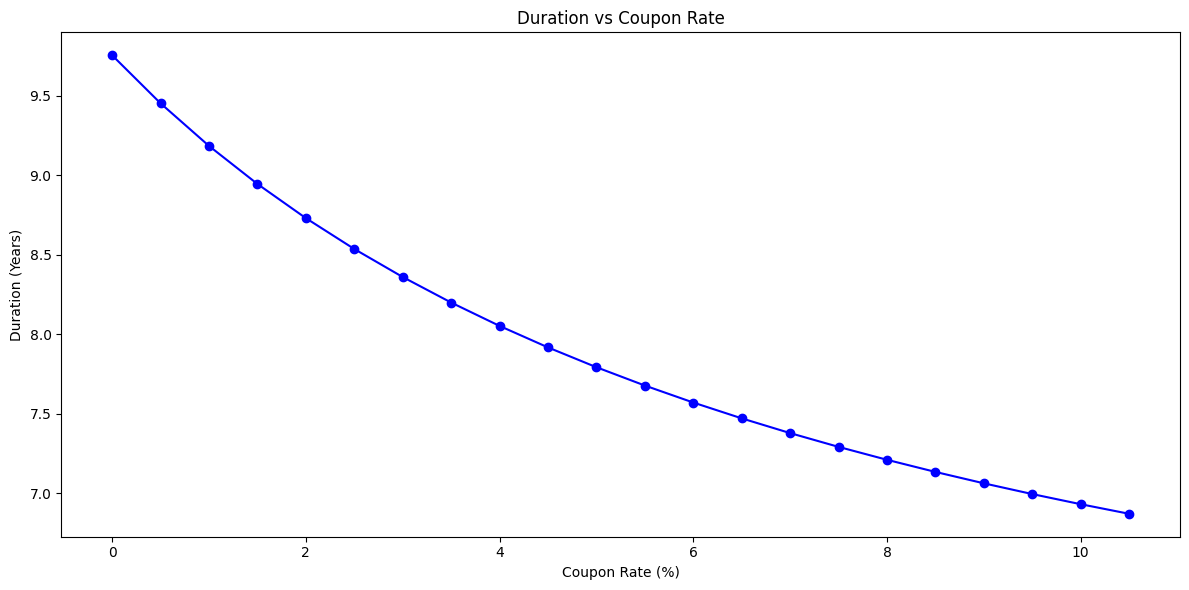

In [51]:
# coupon vs duration plot

coupons = np.arange(0, 11, 0.5)
durations = [calculate_duration(c, ytm, coupon_dates, today_date) for c in coupons]
plt.figure(figsize=(12, 6))
plt.plot(coupons, durations, marker='o', linestyle='-', color='b')
plt.title("Duration vs Coupon Rate")
plt.xlabel("Coupon Rate (%)")
plt.ylabel("Duration (Years)")
plt.tight_layout()
plt.show()

From the data points as well as the curve calculated here, higher coupon rate correlates with a lower duration. This makes sense because with a higher coupon rate, a greater proportion of the "nominal cash value" of the bond is paid before maturity via coupons. Then a change in the yield rate over time has less impact on the price when coupons are higher because less of the cash value of the bond is discounted by potentially higher future rates, and so high-coupon bonds are less exposed to yield / interest rate changes. 

In [119]:
# data loading

ts_duration_data = pd.read_excel("./data/treasury_ts_duration_2025-05-30.xlsx", sheet_name=None, index_col=0)
data_ts = ts_duration_data['database']
clean_ts = ts_duration_data['clean price']
dirty_ts = ts_duration_data['dirty price']
duration_ts = ts_duration_data['duration']

## 2.1

In [67]:
10**4 * duration_ts.iloc[0][207391] / duration_ts.iloc[0][207392]

np.float64(4222.479082922904)

To manage interest rate exposure, we should hold a short position of $4222.48 in bond 207392. 

## 2.2

In [160]:
# Dynamic hedging strategy

first_date = dirty_ts.index[0]

price_duration_df = pd.concat({'dirty prices': dirty_ts, 'duration': duration_ts}, axis=1)
price_duration_df['amt_held_start', 207391] = 10 ** 4
price_duration_df.loc[first_date, ('amt_held_start', 207391)] = 0
price_duration_df['amt_held_end', 207391] = 10 ** 4
price_duration_df['amt_held_end', 207392] = - price_duration_df['amt_held_end', 207391] * price_duration_df['duration', 207391] / price_duration_df['duration', 207392]
price_duration_df['amt_held_start', 207392] = price_duration_df['amt_held_end', 207392].shift(1).fillna(0)

price_duration_df['total_duration_end', 207391] = price_duration_df['amt_held_end', 207391] * price_duration_df['duration', 207391]
price_duration_df['total_duration_end', 207392] = price_duration_df['amt_held_end', 207392] * price_duration_df['duration', 207392]
price_duration_df['total_duration_end', 'total'] = price_duration_df['total_duration_end', 207391] + price_duration_df['total_duration_end', 207392]

price_duration_df['position_value_end', 207391] = price_duration_df['amt_held_end', 207391] * price_duration_df['dirty prices', 207391] / 100
price_duration_df['position_value_end', 207392] = price_duration_df['amt_held_end', 207392] * price_duration_df['dirty prices', 207392] / 100
price_duration_df['position_value_end', 'total'] = price_duration_df['position_value_end', 207391] + price_duration_df['position_value_end', 207392]

price_duration_df['cost_to_hedge', 207391] = (price_duration_df['amt_held_end', 207391] - price_duration_df['amt_held_start', 207391]) * price_duration_df['dirty prices', 207391] / 100
price_duration_df['cost_to_hedge', 207392] = (price_duration_df['amt_held_end', 207392] - price_duration_df['amt_held_start', 207392]) * price_duration_df['dirty prices', 207392] / 100

price_duration_df['cumulative_cost'] = price_duration_df['cost_to_hedge', 207391].cumsum() + price_duration_df['cost_to_hedge', 207392].cumsum()

price_duration_df['total_value_end'] = price_duration_df['position_value_end', 'total'] - price_duration_df['cumulative_cost']

price_duration_df['Daily PnL'] = price_duration_df['total_value_end'].diff()

price_duration_df.sort_index(axis=1, inplace=True)
# price_duration_df

# plt.plot(price_duration_df.index, price_duration_df['total_value_end'])

In [192]:
# static long-only
long_only_amount = 10 ** 4
long_only_performance = (long_only_amount * dirty_ts[207391] - (10 ** 4 * dirty_ts.iloc[0][207391])) / 100
long_only_daily_pnl = long_only_performance.diff()

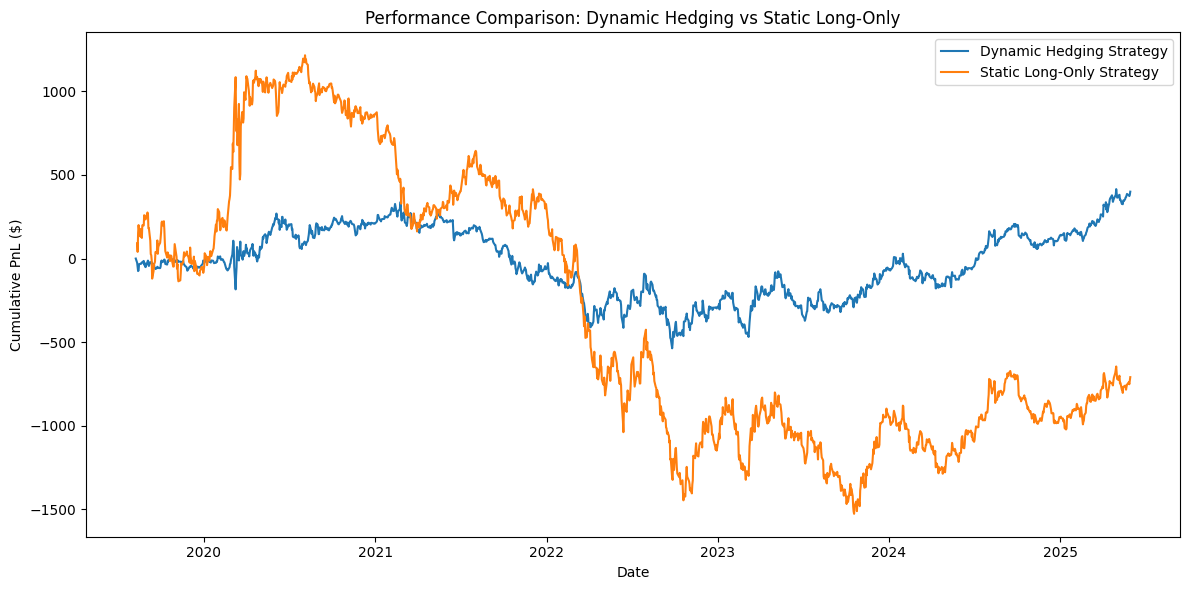

In [193]:
# plot
plt.figure(figsize=(12, 6))
plt.plot(price_duration_df.index, price_duration_df['total_value_end'], label='Dynamic Hedging Strategy')
plt.plot(long_only_daily_pnl.index, long_only_daily_pnl.cumsum(), label='Static Long-Only Strategy')
plt.title('Performance Comparison: Dynamic Hedging vs Static Long-Only')
plt.xlabel('Date')
plt.ylabel('Cumulative PnL ($)')
plt.legend()
plt.tight_layout()
plt.show()

In [114]:
# relevant statistics
def compute_statistics(pnl_series):
    mean = pnl_series.mean()
    std = pnl_series.std()
    min = pnl_series.min()
    max = pnl_series.max()

    max_drawdown = (pnl_series.cumsum().cummax() - pnl_series.cumsum()).max()
    
    return {
        'Mean Daily PnL ($)': mean,
        'Std Dev of Daily PnL ($)': std,
        'Min Daily PnL ($)': min,
        'Max Daily PnL ($)': max,
        'Max Drawdown ($)': max_drawdown
    }

dynamic_stats = compute_statistics(price_duration_df['Daily PnL'])
static_stats = compute_statistics(long_only_daily_pnl)

pd.DataFrame({'Dynamic Hedging': dynamic_stats, 'Static Long-Only': static_stats})

,Dynamic Hedging,Static Long-Only
Mean Daily PnL ($),0.275228,-0.493454
Std Dev of Daily PnL ($),21.293574,42.746223
Min Daily PnL ($),-135.353242,-350.342555
Max Daily PnL ($),120.309334,290.409598
Max Drawdown ($),875.835212,2772.359292


## 2.3

We have hedged away shifts in price in response to generalized interest rate shifts, but this does not account for how bond prices change in response to expected interest rate shifts. It appears that bond 207392 has a higher exposure to duration, which would indicate that its maturity is further away. In this case an expected reversion of interest rates to a higher level might be priced into the price for bond 207392 but not bond 207391 as its maturity could occur before an interest rate increase. 

Additionally, the dynamic hedging process is not free. While we have hedged our position so that our net exposure to duration is zero, the duration factors of the bonds themselves shift in accordance to changes in duration and over time. To maintain the hedge, we have to increase or decrease our position as necessary to track how the duration factors shift, so we have indirect exposure to duration. 

## 2.4

In [135]:
# Locating coupons

one_treasury = data_ts[data_ts.index == 207391].sort_values(by='quote date')
two_treasury = data_ts[data_ts.index == 207392].sort_values(by='quote date')

one_coupon_dates = one_treasury[one_treasury['accrued int'].diff() < 0]['quote date']
two_coupon_dates = two_treasury[two_treasury['accrued int'].diff() < 0]['quote date']

# displaying first 5 dates where coupon is paid for both treasuries
pd.DataFrame({
    '207391 Coupon Dates': one_coupon_dates.head().tolist(),
    '207392 Coupon Dates': two_coupon_dates.head().tolist()})

,207391 Coupon Dates,207392 Coupon Dates
0,2020-02-18,2020-02-18
1,2020-08-17,2020-08-17
2,2021-02-16,2021-02-16
3,2021-08-16,2021-08-16
4,2022-02-15,2022-02-15


## 2.5

In [199]:
coupon_price_df = price_duration_df.copy()

# coupon distributions
one_coupon_amount = one_treasury['cpn rate'].iloc[0] / 200
two_coupon_amount = two_treasury['cpn rate'].iloc[0] / 200

one_coupon_distributions = pd.Series(one_coupon_amount, index=one_coupon_dates)
two_coupon_distributions = pd.Series(two_coupon_amount, index=two_coupon_dates)

coupon_price_df = coupon_price_df.merge(one_coupon_distributions.rename(('unit_coupon', 207391)), left_index=True, right_index=True, how='left').fillna(0)
coupon_price_df = coupon_price_df.merge(two_coupon_distributions.rename(('unit_coupon', 207392)), left_index=True, right_index=True, how='left').fillna(0)

coupon_price_df[('coupon_received', 207391)] = coupon_price_df[('amt_held_start', 207391)] * coupon_price_df[('unit_coupon', 207391)]
coupon_price_df[('coupon_received', 207392)] = coupon_price_df[('amt_held_start', 207392)] * coupon_price_df[('unit_coupon', 207392)]
coupon_price_df['total_cumulative_coupon'] = coupon_price_df[('coupon_received', 207391)].cumsum() + coupon_price_df[('coupon_received', 207392)].cumsum()

coupon_price_df['total_with_coupons'] = coupon_price_df['total_value_end'] + coupon_price_df['total_cumulative_coupon']
coupon_price_df['Daily PnL with coupons'] = coupon_price_df['total_with_coupons'].diff()

In [197]:
# coupons for long-only
long_only_coupon = pd.Series(np.float64(0), index=long_only_performance.index)
for date in one_coupon_dates:
    if date in long_only_coupon.index:
        long_only_coupon.loc[date] = one_coupon_amount * long_only_amount
long_only_performance_with_coupons = long_only_performance + long_only_coupon.cumsum()
long_only_daily_pnl_with_coupons = long_only_daily_pnl.add(long_only_coupon, fill_value=0)

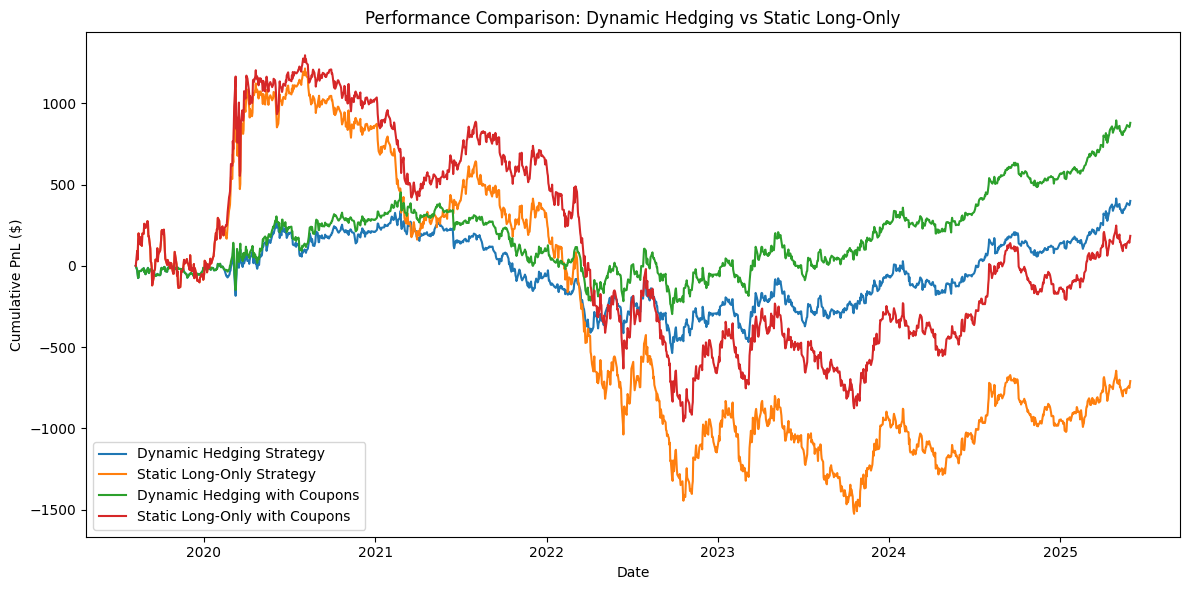

In [196]:
# plots
plt.figure(figsize=(12, 6))
plt.plot(price_duration_df.index, price_duration_df['total_value_end'], label='Dynamic Hedging Strategy')
plt.plot(long_only_daily_pnl.index, long_only_daily_pnl.cumsum(), label='Static Long-Only Strategy')
plt.plot(coupon_price_df.index, coupon_price_df['total_with_coupons'], label='Dynamic Hedging with Coupons')
plt.plot(long_only_daily_pnl_with_coupons.index, long_only_daily_pnl_with_coupons.cumsum(), label='Static Long-Only with Coupons')
plt.title('Performance Comparison: Dynamic Hedging vs Static Long-Only')
plt.xlabel('Date')
plt.ylabel('Cumulative PnL ($)')
plt.legend()
plt.tight_layout()
plt.show()

In [200]:
# tables

dynamic_stats_with_coupons = compute_statistics(coupon_price_df['Daily PnL with coupons'])
static_stats_with_coupons = compute_statistics(long_only_daily_pnl_with_coupons)

pd.DataFrame({
    'Dynamic Hedging': dynamic_stats, 
    'Static Long-Only': static_stats,
    'Dynamic Hedging with Coupons': dynamic_stats_with_coupons, 
    'Static Long-Only with Coupons': static_stats_with_coupons})

,Dynamic Hedging,Static Long-Only,Dynamic Hedging with Coupons,Static Long-Only with Coupons
Mean Daily PnL ($),0.275228,-0.493454,0.606034,0.127078
Std Dev of Daily PnL ($),21.293574,42.746223,20.947993,41.487096
Min Daily PnL ($),-135.353242,-350.342555,-135.353242,-346.428571
Max Daily PnL ($),120.309334,290.409598,120.309334,287.165179
Max Drawdown ($),875.835212,2772.359292,749.324965,2254.617139


# Exercise: Steepener Trade
## 1.1

In [204]:
# data loading

steepener_data = pd.read_excel("./data/steepener_trade_2024-01-02.xlsx", sheet_name=None, index_col=0)
info_steep = steepener_data['info']
clean_steep = steepener_data['clean price']
dirty_steep = steepener_data['dirty price']
duration_steep = steepener_data['duration']

In [216]:
# 207652 is 2 year, 208147 is 10 year
y2_id = 207652
y10_id = 208147

steep_long_money_amt = 5 * (10 ** 7)
steep_long_size = steep_long_money_amt / (dirty_steep.iloc[0][207652])

steep_short_size = - steep_long_size * duration_steep.iloc[0][207652] / duration_steep.iloc[0][208147]
steep_short_money_amt = steep_short_size * (dirty_steep.iloc[0][208147])

print(f"Dollar value of short position: ${steep_short_money_amt:,.2f}")
print(f"Amount of 2-year bonds: {steep_long_size:,}")
print(f"Amount of 10-year bonds: {steep_short_size:,}")

Dollar value of short position: $-14,212,967.75
Amount of 2-year bonds: 549,581.8399044205
Amount of 10-year bonds: -143,565.33077304318


In [236]:
# Dynamic hedging for steepener

first_date = dirty_steep.index[0]

steep_trade_df = pd.concat({'dirty prices': dirty_steep, 'duration': duration_steep}, axis=1)
steep_trade_df['amt_held_end', y2_id] = steep_long_money_amt / steep_trade_df['dirty prices', y2_id]
steep_trade_df['amt_held_start', y2_id] = steep_trade_df['amt_held_end', y2_id].shift(1).fillna(0)

steep_trade_df['amt_held_end', y10_id] = - steep_trade_df['amt_held_end', y2_id] * steep_trade_df['duration', y2_id] / steep_trade_df['duration', y10_id]
steep_trade_df['amt_held_start', y10_id] = steep_trade_df['amt_held_end', y10_id].shift(1).fillna(0)

steep_trade_df['total_duration_end', y2_id] = steep_trade_df['amt_held_end', y2_id] * steep_trade_df['duration', y2_id]
steep_trade_df['total_duration_end', y10_id] = steep_trade_df['amt_held_end', y10_id] * steep_trade_df['duration', y10_id]
steep_trade_df['total_duration_end', 'total'] = steep_trade_df['total_duration_end', y2_id] + steep_trade_df['total_duration_end', y10_id]

steep_trade_df['position_value_end', y2_id] = steep_trade_df['amt_held_end', y2_id] * steep_trade_df['dirty prices', y2_id]
steep_trade_df['position_value_end', y10_id] = steep_trade_df['amt_held_end', y10_id] * steep_trade_df['dirty prices', y10_id]
steep_trade_df['position_value_end', 'total'] = steep_trade_df['position_value_end', y2_id] + steep_trade_df['position_value_end', y10_id]

steep_trade_df['cost_to_hedge', y2_id] = (steep_trade_df['amt_held_end', y2_id] - steep_trade_df['amt_held_start', y2_id]) * steep_trade_df['dirty prices', y2_id]
steep_trade_df['cost_to_hedge', y10_id] = (steep_trade_df['amt_held_end', y10_id] - steep_trade_df['amt_held_start', y10_id]) * steep_trade_df['dirty prices', y10_id]
steep_trade_df['cumulative_cost'] = steep_trade_df['cost_to_hedge', y2_id].cumsum() + steep_trade_df['cost_to_hedge', y10_id].cumsum()

steep_trade_df['total_value_end'] = steep_trade_df['position_value_end', 'total'] - steep_trade_df['cumulative_cost']
steep_trade_df['Daily PnL'] = steep_trade_df['total_value_end'].diff()

# steep_trade_df.sort_index(axis=1, inplace=True)
steep_trade_df = steep_trade_df[['dirty prices', 'duration', 'amt_held_start', 'amt_held_end', 'position_value_end', 'cost_to_hedge', 'cumulative_cost', 'total_value_end', 'Daily PnL']]
steep_trade_df

dirty prices              duration           amt_held_start  \
                 207652      208147    207652    208147         207652   
quote date                                                               
2023-11-09    90.978261   99.000000  2.135193  8.173725       0.000000   
2023-11-10    90.940217   98.789062  2.132450  8.168483  549581.839904   
2023-11-13    91.005774   98.882812  2.124233  8.160898  549811.749238   
2023-11-14    91.397418  100.414062  2.121523  8.174992  549415.685967   
2023-11-15    91.253906   99.742188  2.118771  8.164722  547061.403183   
...                 ...         ...       ...       ...            ...   
2025-05-23    97.904452  100.762021  0.607258  7.147798  510869.148828   
2025-05-27    97.907937  101.224864  0.596299  7.140169  510702.007183   
2025-05-28    97.913829  100.967561  0.593559  7.135270  510683.826589   
2025-05-29    97.917768  101.397758  0.590819  7.135881  510653.094380   
2025-05-30    97.949000  101.685377  0.588080  7.135339  510632.552215   

                            amt_held_end                position_value_end  \
                   208147         207652         208147             207652   
quote date                                                                   
2023-11-09       0.000000  549581.839904 -143565.330773         50000000.0   
2023-11-10 -143565.330773  549811.749238 -143532.875999         50000000.0   
2023-11-13 -143532.875999  549415.685967 -143009.603361         50000000.0   
2023-11-14 -143009.603361  547061.403183 -141969.937568         50000000.0   
2023-11-15 -141969.937568  547921.749925 -142187.400921         50000000.0   
...                   ...            ...            ...                ...   
2025-05-23  -43592.130582  510702.007183  -43387.877729         50000000.0   
2025-05-27  -43387.877729  510683.826589  -42648.859013         50000000.0   
2025-05-28  -42648.859013  510653.094380  -42479.493078         50000000.0   
2025-05-29  -42479.493078  510632.552215  -42278.092074         50000000.0   
2025-05-30  -42278.092074  510469.733518  -42071.832633         50000000.0   

                                       cost_to_hedge                \
                  208147         total        207652        208147   
quote date                                                           
2023-11-09 -1.421297e+07  3.578703e+07  5.000000e+07 -1.421297e+07   
2023-11-10 -1.417948e+07  3.582052e+07  2.090800e+04  3.206177e+03   
2023-11-13 -1.414119e+07  3.585881e+07 -3.604404e+04  5.174267e+04   
2023-11-14 -1.425578e+07  3.574422e+07 -2.151754e+05  1.043971e+05   
2023-11-15 -1.418208e+07  3.581792e+07  7.851000e+04 -2.169027e+04   
...                  ...           ...           ...           ...   
2025-05-23 -4.371850e+06  4.562815e+07 -1.636391e+04  2.058093e+04   
2025-05-27 -4.317125e+06  4.568288e+07 -1.780024e+03  7.480707e+04   
2025-05-28 -4.289051e+06  4.571095e+07 -3.009108e+03  1.710047e+04   
2025-05-29 -4.286904e+06  4.571310e+07 -2.011443e+03  2.042161e+04   
2025-05-30 -4.278090e+06  4.572191e+07 -1.594793e+04  2.097357e+04   

           cumulative_cost total_value_end     Daily PnL  
                                                          
quote date                                                
2023-11-09    3.578703e+07    0.000000e+00           NaN  
2023-11-10    3.581115e+07    9.375307e+03   9375.307181  
2023-11-13    3.582685e+07    3.196314e+04  22587.837577  
2023-11-14    3.571607e+07    2.815506e+04  -3808.086287  
2023-11-15    3.577289e+07    4.503111e+04  16876.050837  
...                    ...             ...           ...  
2025-05-23    4.242864e+07    3.199511e+06   6119.023200  
2025-05-27    4.250167e+07    3.181209e+06 -18301.759409  
2025-05-28    4.251576e+07    3.195192e+06  13982.789276  
2025-05-29    4.253417e+07    3.178929e+06 -16263.110139  
2025-05-30    4.253919e+07    3.182717e+06   3787.951923  

[388 rows x 16 columns]

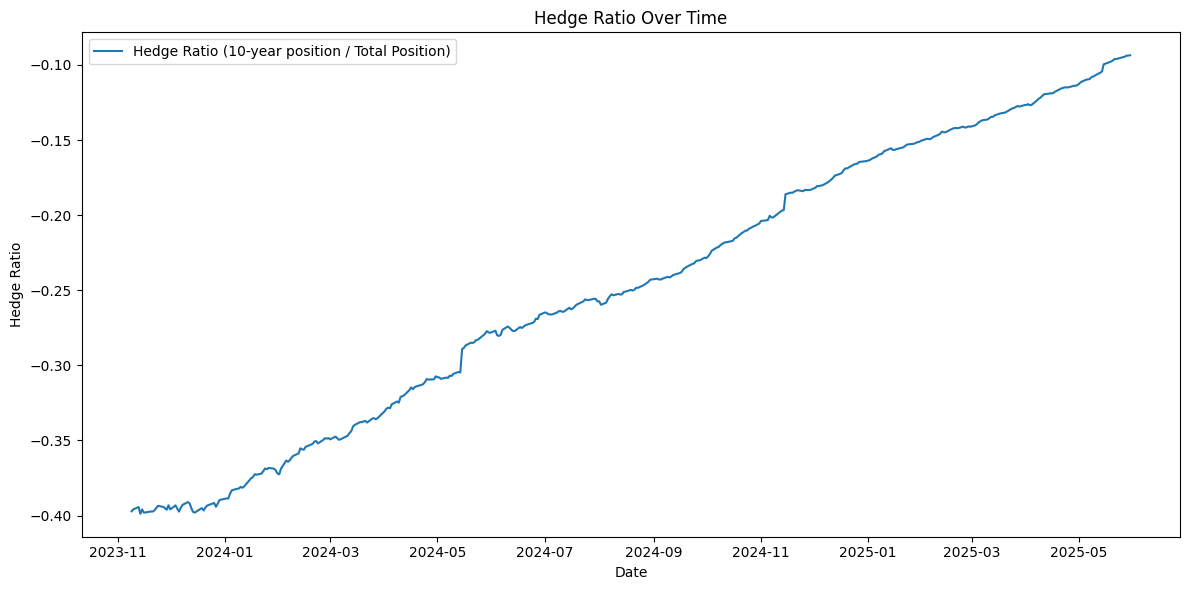

In [ ]:
# plots (hedge ratio)
hedge_ratio_series = steep_trade_df['position_value_end', y10_id] / steep_trade_df['position_value_end', 'total']

plt.figure(figsize=(12, 6))
plt.plot(hedge_ratio_series, label='Hedge Ratio (10-year position / Total Position)')
plt.title('Hedge Ratio Over Time')
plt.xlabel('Date')
plt.ylabel('Hedge Ratio')
plt.legend()
plt.tight_layout()
plt.show()

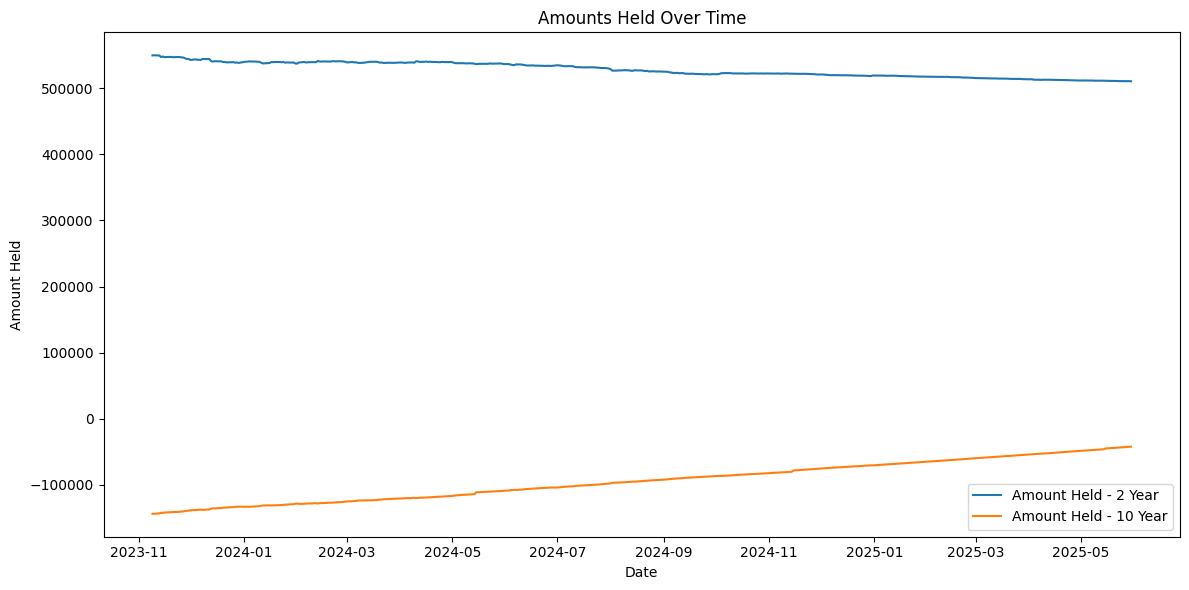

In [232]:
# plots (number of 2y vs number of 10y)
plt.figure(figsize=(12, 6))
plt.plot(steep_trade_df.index, steep_trade_df['amt_held_end', y2_id], label='Amount Held - 2 Year')
plt.plot(steep_trade_df.index, steep_trade_df['amt_held_end', y10_id], label='Amount Held - 10 Year')
plt.title('Amounts Held Over Time')
plt.xlabel('Date')
plt.ylabel('Amount Held')
plt.legend()
plt.tight_layout()
plt.show()

In [233]:
# reported values for last day in sample
last_num_2y = steep_trade_df['amt_held_end', y2_id].iloc[-1]
last_num_10y = steep_trade_df['amt_held_end', y10_id].iloc[-1]

print(f"Number of 2-year bonds held at the end: {last_num_2y:,.2f}")
print(f"Number of 10-year bonds held at the end: {last_num_10y:,.2f}")

Number of 2-year bonds held at the end: 510,469.73
Number of 10-year bonds held at the end: -42,071.83


## 1.3

In [254]:
# steepener pnl calc
steep_pnl_df = steep_trade_df.copy()
steep_pnl_df = steep_pnl_df[['position_value_end', 'cost_to_hedge']]

steep_pnl_df['cumulative_cost', y2_id] = steep_pnl_df['cost_to_hedge', y2_id].cumsum()
steep_pnl_df['cumulative_cost', y10_id] = steep_pnl_df['cost_to_hedge', y10_id].cumsum()

steep_pnl_df['account_value', y2_id] = steep_pnl_df['position_value_end', y2_id] - steep_pnl_df['cumulative_cost', y2_id]
steep_pnl_df['account_value', y10_id] = steep_pnl_df['position_value_end', y10_id] - steep_pnl_df['cumulative_cost', y10_id]
steep_pnl_df['account_value', 'total'] = steep_pnl_df['account_value', y2_id] + steep_pnl_df['account_value', y10_id]

steep_pnl_df['daily_pnl', y2_id] = steep_pnl_df['account_value', y2_id].diff().fillna(0)
steep_pnl_df['daily_pnl', y10_id] = steep_pnl_df['account_value', y10_id].diff().fillna(0)
steep_pnl_df['total_daily_pnl'] = steep_pnl_df['daily_pnl', y2_id] + steep_pnl_df['daily_pnl', y10_id]

# printing profit
# first day for which we have reasonable data (the second day as we only enter the position during the first day)
start_date = steep_pnl_df.index[1]
end_date = steep_pnl_df.index[-1]

print("first date profit:", steep_pnl_df.loc[start_date, 'total_daily_pnl'].item())
print("last date profit:", steep_pnl_df.loc[end_date, 'total_daily_pnl'].item())
print("difference:", steep_pnl_df.loc[end_date, 'total_daily_pnl'].item() - steep_pnl_df.loc[start_date, 'total_daily_pnl'].item())

first date profit: 9375.30718096532
last date profit: 3787.9519234676845
difference: -5587.355257497635


## 1.4

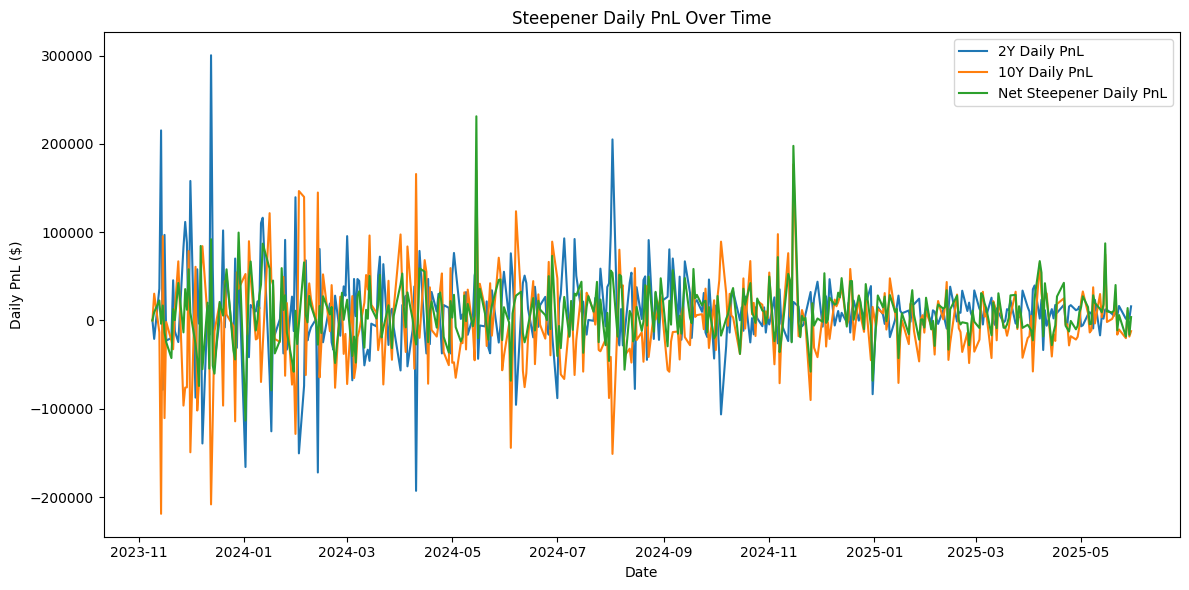

In [252]:
# plot pnl over time
plt.figure(figsize=(12, 6))
plt.plot(steep_pnl_df.index, steep_pnl_df['daily_pnl', y2_id], label='2Y Daily PnL')
plt.plot(steep_pnl_df.index, steep_pnl_df['daily_pnl', y10_id], label='10Y Daily PnL')
plt.plot(steep_pnl_df.index, steep_pnl_df['total_daily_pnl'], label='Net Steepener Daily PnL')
plt.title('Steepener Daily PnL Over Time')
plt.xlabel('Date')
plt.ylabel('Daily PnL ($)')
plt.legend()
plt.tight_layout()
plt.show()

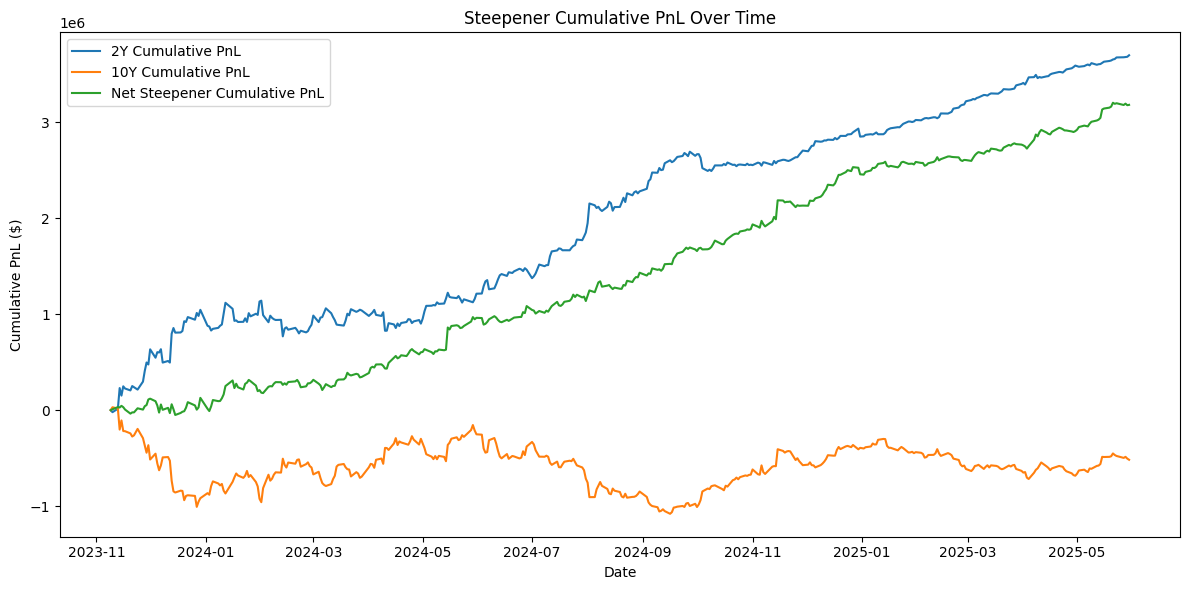

In [255]:
# cumulative Pnls
plt.figure(figsize=(12, 6))
plt.plot(steep_pnl_df.index, steep_pnl_df['account_value', y2_id], label='2Y Cumulative PnL')
plt.plot(steep_pnl_df.index, steep_pnl_df['account_value', y10_id], label='10Y Cumulative PnL')
plt.plot(steep_pnl_df.index, steep_pnl_df['account_value', 'total'], label='Net Steepener Cumulative PnL')
plt.title('Steepener Cumulative PnL Over Time')
plt.xlabel('Date')
plt.ylabel('Cumulative PnL ($)')
plt.legend()
plt.tight_layout()
plt.show()

## 1.5

In [265]:
# calculating coupons
# NOTE: the hint says to use the clean-dirty prices where they match to find coupon dates
# but this is really impractical. Instead, we use the jump in the dirty - clean diff to find coupon dates
clean_dirty_steep = pd.concat({'clean prices': clean_steep, 'dirty prices': dirty_steep}, axis=1)

def extract_coupon_dates(dirty_prices, clean_prices):
    diff_series = dirty_prices - clean_prices
    coupon_dates = diff_series[diff_series.diff() < 0].index
    return coupon_dates

y2_coupon_dates = extract_coupon_dates(dirty_steep[y2_id], clean_steep[y2_id])
y10_coupon_dates = extract_coupon_dates(dirty_steep[y10_id], clean_steep[y10_id])

# coupon amounts
y2_coupon_amount = info_steep.loc[y2_id, 'cpn rate'] / 2
y10_coupon_amount = info_steep.loc[y10_id, 'cpn rate'] / 2

# creating series to merge into df
y2_coupon_series = pd.Series(y2_coupon_amount, index=y2_coupon_dates)
y10_coupon_series = pd.Series(y10_coupon_amount, index=y10_coupon_dates)

In [267]:
coupon_pnl_df = steep_pnl_df.copy()
coupon_pnl_df = coupon_pnl_df[['account_value', 'daily_pnl']]
coupon_pnl_df = coupon_pnl_df.merge(y2_coupon_series.rename(('unit_coupon', y2_id)), left_index=True, right_index=True, how='left').fillna(0)
coupon_pnl_df = coupon_pnl_df.merge(y10_coupon_series.rename(('unit_coupon', y10_id)), left_index=True, right_index=True, how='left').fillna(0)

coupon_pnl_df[('coupon_received', y2_id)] = coupon_pnl_df[('unit_coupon', y2_id)] * steep_trade_df['amt_held_start', y2_id]
coupon_pnl_df[('coupon_received', y10_id)] = coupon_pnl_df[('unit_coupon', y10_id)] * steep_trade_df['amt_held_start', y10_id]
coupon_pnl_df[('account_value_with_coupons', y2_id)] = coupon_pnl_df['account_value', y2_id] + coupon_pnl_df[('coupon_received', y2_id)].cumsum()
coupon_pnl_df[('account_value_with_coupons', y10_id)] = coupon_pnl_df['account_value', y10_id] + coupon_pnl_df[('coupon_received', y10_id)].cumsum()
coupon_pnl_df[('account_value_with_coupons', 'total')] = coupon_pnl_df[('account_value_with_coupons', y2_id)] + coupon_pnl_df[('account_value_with_coupons', y10_id)]

coupon_pnl_df[('daily_pnl_with_coupons', y2_id)] = coupon_pnl_df[('account_value_with_coupons', y2_id)].diff().fillna(0)
coupon_pnl_df[('daily_pnl_with_coupons', y10_id)] = coupon_pnl_df[('account_value_with_coupons', y10_id)].diff().fillna(0)
coupon_pnl_df['total_daily_pnl_with_coupons'] = coupon_pnl_df[('daily_pnl_with_coupons', y2_id)] + coupon_pnl_df[('daily_pnl_with_coupons', y10_id)]

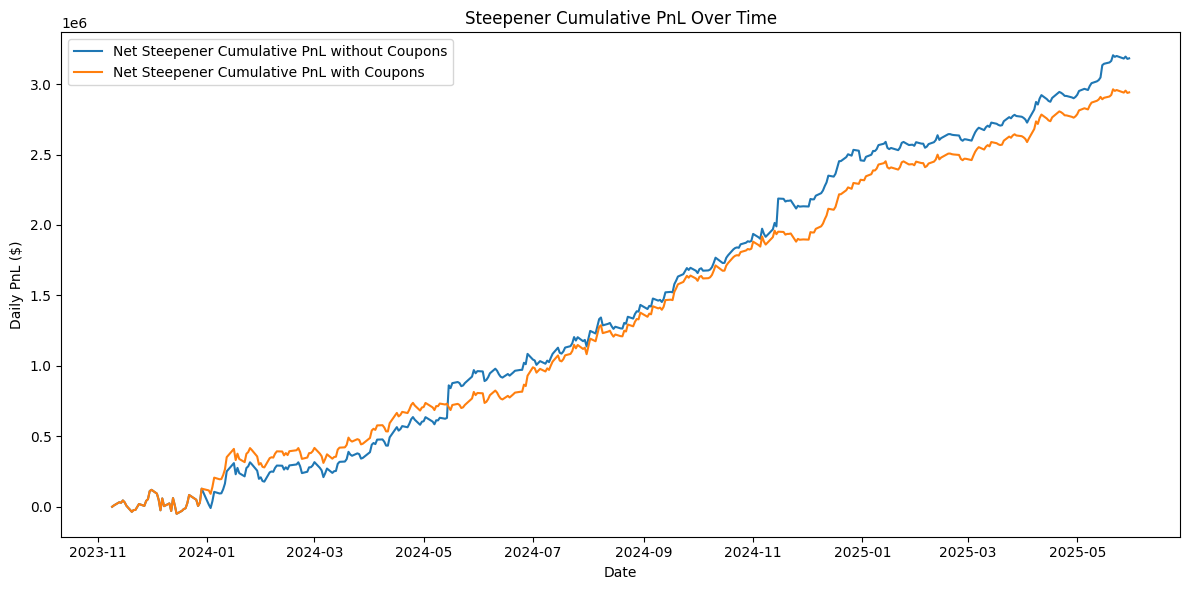

In [269]:
# plot comparison of cumulative non-coupon with coupon pnl
plt.figure(figsize=(12, 6))
plt.plot(steep_pnl_df.index, steep_pnl_df['total_daily_pnl'].cumsum(), label='Net Steepener Cumulative PnL without Coupons')
plt.plot(coupon_pnl_df.index, coupon_pnl_df['total_daily_pnl_with_coupons'].cumsum(), label='Net Steepener Cumulative PnL with Coupons')
plt.title('Steepener Cumulative PnL Over Time')
plt.xlabel('Date')
plt.ylabel('Daily PnL ($)')
plt.legend()
plt.tight_layout()
plt.show()

In [272]:
# print total profit
print(f"Steepener total profit without coupons: ${steep_pnl_df['total_daily_pnl'].sum():,.2f}")
print(f"Steepener total profit with coupons: ${coupon_pnl_df['total_daily_pnl_with_coupons'].sum():,.2f}")

Steepener total profit without coupons: $3,182,717.13
Steepener total profit with coupons: $2,941,053.20
